In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

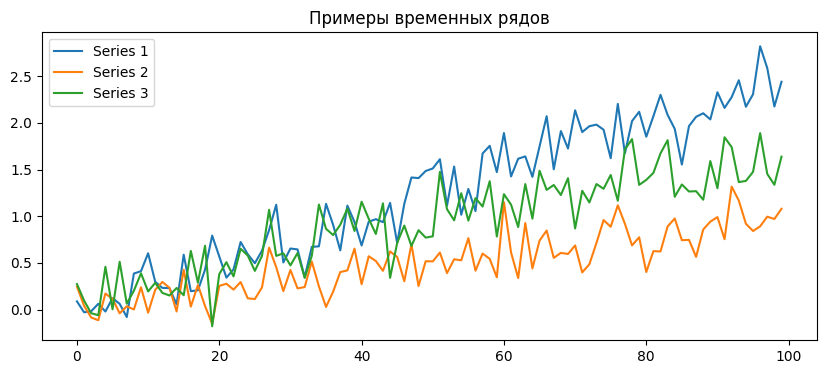

In [3]:
def generate_time_series(n_samples, length, trend_coef=0.1, amplitude=1.0, freq=0.1, noise_std=0.2):
    """Генерация временных рядов с трендом, периодичностью и шумом."""
    time = np.linspace(0, 10, length)
    series = []
    params = []
    
    for _ in range(n_samples):
        # Случайные параметры для разнообразия
        random_trend = trend_coef * np.random.randn()
        random_amp = amplitude * (0.5 + np.random.rand())
        random_freq = freq * (0.8 + 0.4 * np.random.rand())
        
        # Генерация ряда: тренд + синус + шум
        y = random_trend * time + random_amp * np.sin(random_freq * time) + noise_std * np.random.randn(length)
        series.append(y)
        params.append((random_trend, random_amp, random_freq))
    
    return np.array(series), np.array(params)

np.random.seed(3)

# Пример генерации
n_samples = 1000
length = 100
X, true_params = generate_time_series(n_samples, length)

# Визуализация
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.plot(X[i], label=f"Series {i+1}")
plt.legend()
plt.title("Примеры временных рядов")
plt.show()

In [4]:
import gpytorch

In [5]:
kernel = gpytorch.kernels.RBFKernel()
# Параметры ядра можно обучать (length_scale, variance)
print(kernel.lengthscale, kernel)  # По умолчанию ≈1.0

tensor([[0.6931]], grad_fn=<SoftplusBackward0>) RBFKernel(
  (raw_lengthscale_constraint): Positive()
)


# train пример

In [6]:
# class CovarianceTrackingGP(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super().__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel() + 
#             gpytorch.kernels.LinearKernel()
#         )
#         self.covariance_history = []  # Здесь будем сохранять матрицы
    
#     def forward(self, x):
#         mean = self.mean_module(x)
#         covar = self.covar_module(x)
#         if self.training:
#             # Сохраняем ковариацию на каждом шаге
#             self.covariance_history.append(
#                 covar.evaluate_kernel().detach().numpy().copy()
#             )
#         return gpytorch.distributions.MultivariateNormal(mean, covar)

class TimeSeriesGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + 
            gpytorch.kernels.LinearKernel() +
            gpytorch.kernels.PeriodicKernel()
        )
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

def fit_gp(time, y, num_iter=20):
    train_x = torch.from_numpy(time).float()
    train_y = torch.from_numpy(y).float()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = TimeSeriesGP(train_x, train_y, likelihood)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    losses = []
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()    
    
    # Визуализация результатов
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        test_x = torch.linspace(0, time[-1], 100).float()
        observed_pred = likelihood(model(test_x))
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Данные")
        plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label="Предсказание")
        plt.fill_between(
            test_x.numpy(),
            observed_pred.confidence_region()[0].numpy(),
            observed_pred.confidence_region()[1].numpy(),
            alpha=0.2
        )
        plt.title("Аппроксимация временного ряда с помощью GP")
        plt.legend()
        plt.show()
    
    return model, likelihood, losses

# Пример использования
model, likelihood, losses = fit_gp(time, y_linear_sine)

NameError: name 'time' is not defined

In [7]:
class TrackingGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + 
            gpytorch.kernels.LinearKernel()
        )
        self.snapshots = []
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)
    
    def take_snapshot(self, x):
        with torch.no_grad():
            covar = self.covar_module(x).evaluate()
            self.snapshots.append(covar.numpy().copy())
            
def plot_covariance_structure(model, train_x, steps_to_plot=[0, 10, 30, 99], submatrix_size=20):
    plt.figure(figsize=(15, 10))
    
    # Вычисляем полную матрицу для каждого шага
    for i, step in enumerate(steps_to_plot):
        # Временно устанавливаем параметры модели на состояние этого шага
        with torch.no_grad():
            # Для простоты будем считать, что можем воспроизвести матрицу
            # В реальности вам нужно сохранять состояния модели на каждом шаге
            covar = model.covar_module(train_x[:submatrix_size]).evaluate()
        
        plt.subplot(2, len(steps_to_plot)//2, i+1)
        plt.imshow(covar.numpy(), cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title(f"Шаг {step}")
    
    plt.suptitle("Эволюция структуры ковариационной матрицы", y=1.02)
    plt.tight_layout()
    plt.show()
    
    
# В обучении:
model = TrackingGP(train_x, train_y, likelihood)
for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        model.take_snapshot(train_x[:20])  # Сохраняем подматрицу 20x20

NameError: name 'train_x' is not defined

In [8]:
def plot_eigenvalue_evolution(snapshots):
    eigenvalues = []
    for cov in snapshots:
        eigvals = np.linalg.eigvalsh(cov)
        eigenvalues.append(eigvals)
    
    plt.figure(figsize=(10, 6))
    for i in range(min(5, len(eigenvalues[0]))):  # Первые 5 собственных значений
        plt.plot([e[i] for e in eigenvalues], label=f'Собств. значение {i+1}')
    
    plt.xlabel("Шаг обучения")
    plt.ylabel("Значение")
    plt.title("Эволюция собственных значений ковариационной матрицы")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_eigenvalue_evolution(model.snapshots)

NameError: name 'model' is not defined

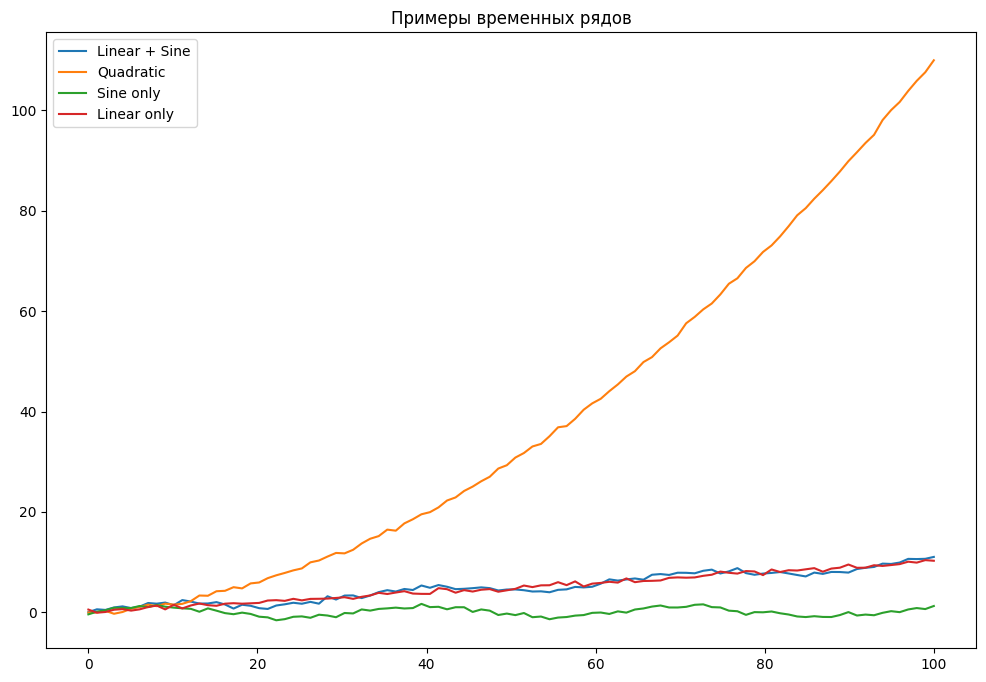

In [9]:
def generate_time_series(length=100, trend_coef=0.2, amplitude=1.0, freq=0.5, noise_std=0.1, 
                        series_type='linear_sine'):
    time = np.linspace(0, length, length)
    
    if series_type == 'linear_sine':
        y = trend_coef * time + amplitude * np.sin(freq * time) + noise_std * np.random.randn(length)
    elif series_type == 'quadratic':
        y = 0.01 * time**2 + trend_coef * time + noise_std * np.random.randn(length)
    elif series_type == 'sine_only':
        y = amplitude * np.sin(freq * time) + noise_std * np.random.randn(length)
    elif series_type == 'linear_only':
        y = trend_coef * time + noise_std * np.random.randn(length)
    else:
        raise ValueError("Unknown series type")
    
    return time, y

# Генерация нескольких примеров
time, y_linear_sine = generate_time_series(100, 0.1, 1.0, 0.2, 0.3, 'linear_sine')
_, y_quadratic = generate_time_series(100, 0.1, 1.0, 0.2, 0.3, 'quadratic')
_, y_sine = generate_time_series(100, 0.1, 1.0, 0.2, 0.3, 'sine_only')
_, y_linear = generate_time_series(100, 0.1, 1.0, 0.2, 0.3, 'linear_only')

plt.figure(figsize=(12, 8))
plt.plot(time, y_linear_sine, label='Linear + Sine')
plt.plot(time, y_quadratic, label='Quadratic')
plt.plot(time, y_sine, label='Sine only')
plt.plot(time, y_linear, label='Linear only')
plt.legend()
plt.title("Примеры временных рядов")
plt.show()

In [10]:
# модель для шума
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# модель для функции
model = CovarianceTrackingGP(train_x, train_y, likelihood)

# модель-функция априорного распределения
model.train()
# модель-функция шума
likelihood.train()  

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
losses = []

for i in range(100):
    optimizer.zero_grad()
    # Forward pass (вычисление априорного распределения)
    output = model(train_x)  
    # Вычисление MLL
    loss = -mll(output, train_y)
    losses.append(loss.detach().numpy())  
    # Backprop
    loss.backward() 
    # Обновление параметров
    optimizer.step()  
    
plt.plot([mat[0, 0] for mat in model.covariance_history], label='Диагональ ковариации (K(0,0))')
plt.xlabel("Шаг обучения")
plt.ylabel("Значение ковариации")
plt.title("Эволюция диагонального элемента ковариационной матрицы")
plt.legend()
plt.show()
    

NameError: name 'CovarianceTrackingGP' is not defined

In [11]:
# steps_to_plot = [0, 5, 10, 15, 19]
steps_to_plot = [0, 20, 40, 60, 80, 99]

def plot_covariance_evolution(model, steps_to_plot=[0, 10, 30, 99]):
    plt.figure(figsize=(12, 6))
    for i, step in enumerate(steps_to_plot):
        plt.subplot(2, 3, i+1)
        plt.imshow(model.covariance_history[step][:20, :20], cmap='viridis')
        plt.colorbar()
        
        # Получаем параметры ядер
        if isinstance(model.covar_module.base_kernel, gpytorch.kernels.AdditiveKernel):
            rbf_ls = model.covar_module.base_kernel.kernels[0].lengthscale.item()
            lin_var = model.covar_module.base_kernel.kernels[1].variance.item()
            title = f"Шаг {step}\nRBF ls: {rbf_ls:.2f}\nLinear var: {lin_var:.2f}"
        else:
            rbf_ls = model.covar_module.base_kernel.lengthscale.item()
            title = f"Шаг {step}\nRBF ls: {rbf_ls:.2f}"
        
        plt.title(title)
    plt.suptitle("Эволюция ковариационной матрицы", y=1.02)
    plt.tight_layout()
    plt.show()


# Пример вызова
plot_covariance_evolution(model, steps_to_plot)

NameError: name 'model' is not defined

In [12]:
model.eval()
likelihood.eval()

length = train_x.shape[0]

with torch.no_grad():
    test_x = torch.linspace(0,  length, length).float()
    observed_pred = likelihood(model(test_x))
    
    # Получаем параметры для заголовка
    if isinstance(model.covar_module.base_kernel, gpytorch.kernels.AdditiveKernel):
        rbf_ls = model.covar_module.base_kernel.kernels[0].lengthscale.item()
        lin_var = model.covar_module.base_kernel.kernels[1].variance.item()
        title = f"Предсказание GP\nRBF ls: {rbf_ls:.2f}, Linear var: {lin_var:.2f}"
    else:
        rbf_ls = model.covar_module.base_kernel.lengthscale.item()
        title = f"Предсказание GP\nRBF ls: {rbf_ls:.2f}"
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Данные")
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label="Предсказание")
    plt.fill_between(
        test_x.numpy(),
        observed_pred.confidence_region()[0].numpy(),
        observed_pred.confidence_region()[1].numpy(),
        alpha=0.2
    )
    plt.title(title)
    plt.legend()
    plt.show()

NameError: name 'model' is not defined

# Остальное

In [3]:
# step 1 
class GaussianProcessModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + 
            gpytorch.kernels.LinearKernel()  # Для тренда
        )
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)


    
model = GaussianProcessModel(train_x, train_y, likelihood)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


NameError: name 'gpytorch' is not defined

In [36]:
model.covar_module

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

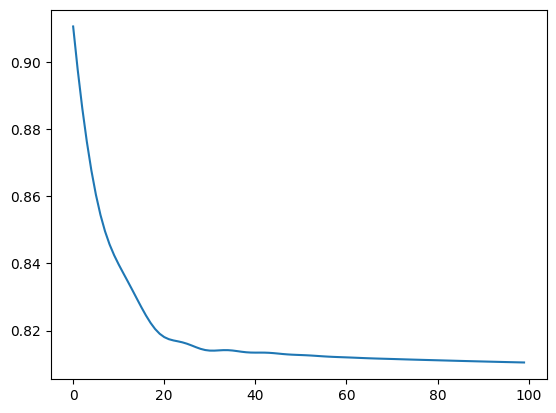

In [26]:
# модель-функция априорного распределения
model.train()
# модель-функция шума
likelihood.train()  

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
losses = []

for i in range(100):
    optimizer.zero_grad()
    # Forward pass (вычисление априорного распределения)
    output = model(train_x)  
    # Вычисление MLL
    loss = -mll(output, train_y)
    losses.append(loss.detach().numpy())  
    # Backprop
    loss.backward() 
    # Обновление параметров
    optimizer.step()  
    
plt.plot(losses)

/root/patrec_time_series/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


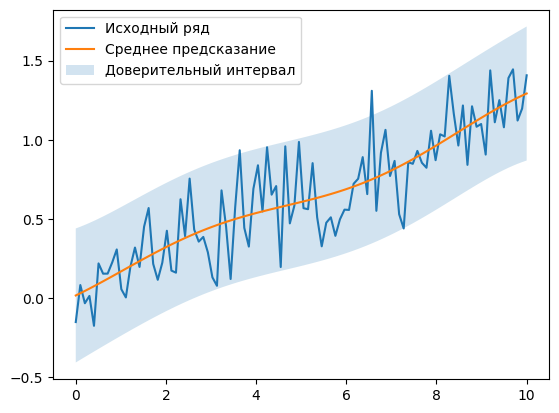

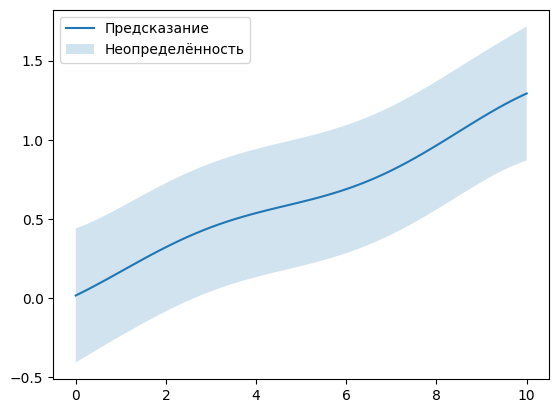

In [24]:
# Переключаем в режим предсказания
model.eval()  
likelihood.eval()

with torch.no_grad():
    plt.figure(1)
    test_x = torch.linspace(0, 10, 100)
    observed_pred = likelihood(model(test_x))
    
    lower, upper = observed_pred.confidence_region()
    plt.plot(test_x, train_y, label="Исходный ряд")
    plt.plot(test_x, observed_pred.mean, label="Среднее предсказание")
    plt.fill_between(test_x, lower, upper, alpha=0.2, label="Доверительный интервал")
    plt.legend()
    plt.plot()
    
    plt.figure(2)
    test_x = torch.linspace(0, 10, 100)
    # Учёт шума
    observed_pred = likelihood(model(test_x))  
    # 95% доверительный интервал
    lower, upper = observed_pred.confidence_region()  
    plt.plot(test_x, observed_pred.mean, label="Предсказание")
    plt.fill_between(test_x, lower, upper, alpha=0.2, label="Неопределённость")
    plt.legend()
    plt.plot()

In [3]:
from experiment_scripts.HAR_prep import load_dataset

X_train, y_train, X_test, y_test, le_dict = load_dataset('data/HAR_bench/versions/1/UCI_HAR_Dataset/')
# X_train, y_train, X_test, y_test = load_dataset('data/HAR_bench/versions/1/UCI_HAR_Dataset/')

/root/patrec_time_series/experiment_scripts/HAR_prep.py:12: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(prefix + f, header=None, sep='\s+')
/root/patrec_time_series/experiment_scripts/HAR_prep.py:31: SyntaxWarning: invalid escape sequence '\s'
  y = pd.read_csv(prefix + group + '/y_'+group+'.txt', header=None, sep='\s+').values


Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352,)
Test Set:
X_test (2947, 128, 9) y_test (2947,)


In [11]:
# le_dict['Label_encoder'].inverse_transform(y_test)
y_test

array([2, 2, 2, ..., 5, 5, 5])

In [12]:
le_dict['Label_encoder'].classes_

array(['Laying', 'Sitting', 'Standing', 'Walking', 'Walking Downstairs',
       'Walking Upstairs'], dtype='<U18')